### XGBoost 
<hr>


Estudos sobre a biblioteca XGBoost



<p align=center>
<img src="https://www.dataapplab.com/wp-content/uploads/2017/08/xgboost.png" width="50%"></p>



<br>
<hr>






In [2]:
import numpy as np 
import pandas as pd
from hyperopt import hp,fmin, Trials, tpe
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, recall_score
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
path = '/content/drive/My Drive/Inteligência Artificial - Colab/Detecção de Fraude /creditcard.csv'
data = pd.read_csv(path)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = data.drop('Class', axis=1)
y = data['Class']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


scaler = QuantileTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
model = xgb.XGBClassifier(learning_rate=0.002, max_depth=13, n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



### Features Importance XGBoost 

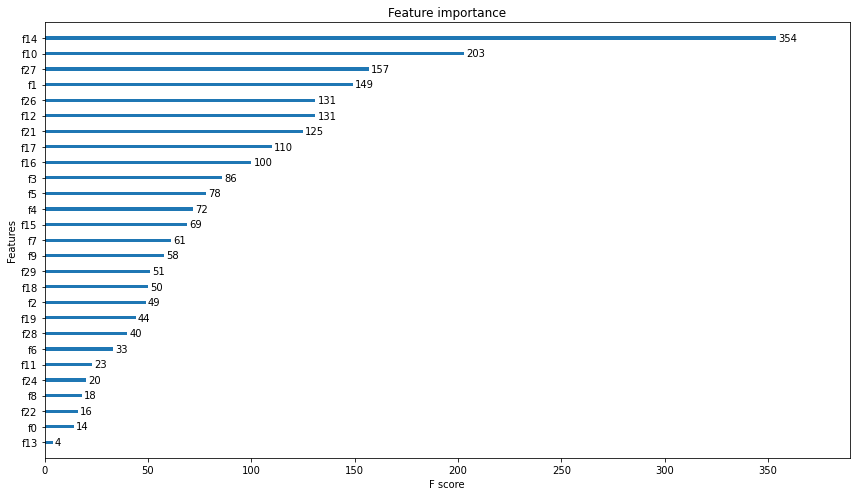

In [6]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(model, ax=ax)
plt.grid(False)
plt.tight_layout()

<br>
<hr>

### Hiperparâmetros

Principais hiperparâmetros do XGBoost

<br>

In [7]:
mdl = XGBClassifier(max_depth=13,
                    learning_rate=0.001,
                    n_estimators=100,
                    verbosity=0,
                    booster='dart',
                    gamma=3,
                    min_child_weight=3,
                    max_delta_step=7,
                    subsample=1,
                    sampling_method='gradient_based',
                    colsample_bytree=0.8,
                    colsample_bylevel=0.8,
                    comsample_bynode=0.8,
                    reg_lambda=1,
                    reg_alpha=1,
                    tree_method='gpu_hist',
                    max_leaves=25,
                    feature_selector=10,
                    scale_pos_weight=2,
                    random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



<br>
<hr>

### Tuning Hiperparâmetros 

Vou Tunar os principais hiperparâmetros do XGBoost, há mais de 30 parâmetros disponíveis no modelo, mas nem todos são úteis para aumentar a performace do modelo. 

<br>

In [8]:
# função objetivo 

def objective(params):
  return -average_precision_score(y_test, y_pred)

In [9]:
# distribuição de parâmetros 

spaces = {'n_estimators': hp.randint('n_estimators', 3000),
          'learning_rate': hp.loguniform('learning_rate', 1e-9, 1e-1),
          'max_depth': hp.randint('max_depth', 30),
          'min_child_weight': hp.uniform('min_child_weight', 0,20),
          'reg_lambda': hp.uniform('reg_lambda', 0.001, 3),
          'reg_alpha': hp.uniform('reg_alpha', 0.001, 3),
          'gamma': hp.uniform('gamma', 0,10),
          'max_delta_step': hp.uniform('max_delta_step', 0, 10),
          'max_leaves': hp.randint('max_leaves', 30),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1,1.0),
          'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
          'scale_pos_weight': hp.randint('scale_pos_weight', 10)}

In [10]:
trials = Trials()
tuning_hyperparameters = fmin(objective, spaces, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

100%|██████████| 50/50 [00:01<00:00, 32.48it/s, best loss: -0.7563078899780487]


In [11]:
# melhores parâmetros 
tuning_hyperparameters

{'colsample_bylevel': 0.6461901425375304,
 'colsample_bytree': 0.586472124272878,
 'gamma': 1.2893715917668624,
 'learning_rate': 1.0731453109087752,
 'max_delta_step': 2.9793525635993245,
 'max_depth': 27,
 'max_leaves': 20,
 'min_child_weight': 16.649019031068477,
 'n_estimators': 1044,
 'reg_alpha': 0.1440380877781203,
 'reg_lambda': 2.8522598478470127,
 'scale_pos_weight': 8}

In [16]:
# XGBoost tunado  
mdl = XGBClassifier(n_estimators=1044,
                      learning_rate=1.073,
                      max_depth=27,
                      min_child_weight=16,
                      reg_lambda=2.85,
                      reg_alpha=0.144,
                      gamma=1,
                      max_delta_step=2,
                      max_leaves=20,
                      colsample_bytree=0.58,
                      colsample_bylevel=0.64,
                      scale_pos_weight=8,
                      random_state=42)
  
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.84      0.86       136

    accuracy                           1.00     85443
   macro avg       0.94      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443

